# Importare le Librerie Necessarie

In [1]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go

# Lettura dati

In [2]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [3]:
data_inizio = '2014-09-17'
data_fine = '2023-12-31'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3388,2023-12-27,38504.562500
3389,2023-12-28,39108.300781
3390,2023-12-29,38515.289062
3391,2023-12-30,38080.046875


# Preparazione dei Periodi di 30 Giorni e train_test_split

In [4]:
# Estrarre periodi di lunghezza 30 giorni dai dati
L = 30
periods = [dati.iloc[i:i + L] for i in range(len(dati) - L + 1)]

# Suddivisione dei periodi in train (70%) e validation/test (30%)
train_periods, validation_periods = train_test_split(periods, test_size=0.3, random_state=42)
validation_periods, test_periods = train_test_split(validation_periods, test_size=0.5, random_state=42)

# Visualizzare il numero di periodi in ciascun insieme
print(f"Train periods: {len(train_periods)}, Validation periods: {len(validation_periods)}, Test periods: {len(test_periods)}")

Train periods: 2354, Validation periods: 505, Test periods: 505


# Definizione dell'Ambiente Personalizzato TradingEnv per Train e Validation

In [5]:
class TradingEnv(gym.Env):
    def __init__(self, periods, initial_cash=1000, initial_btc=0):
        super(TradingEnv, self).__init__()
        
        self.periods = periods
        self.initial_cash = initial_cash
        self.initial_btc = initial_btc
        self.current_step = 0
        self.current_period = None
        self.initial_price = None

        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(30,), dtype=np.float32  # Assicuriamo che la dimensione sia sempre (30,)
        )
    
    def reset(self):
        self.current_period = random.choice(self.periods).reset_index(drop=True)
        self.current_step = 0
        self.cash = self.initial_cash
        self.btc = self.initial_btc
        self.initial_price = self.current_period['Price'].iloc[self.current_step]
        
        # Prima osservazione, riempita con zeri se necessario
        obs = self.current_period['Price'].values[:self.current_step + 1]
        return np.pad(obs, (0, 30 - len(obs)), mode='constant')

    def step(self, action):
        percentage = action[0]
        price = self.current_period['Price'].iloc[self.current_step]

        if percentage < 0:  # Vendita
            btc_to_sell = -percentage * self.btc
            self.btc -= btc_to_sell
            self.cash += btc_to_sell * price
        elif percentage > 0:  # Acquisto
            cash_to_spend = percentage * self.cash
            btc_bought = cash_to_spend / price
            self.btc += btc_bought
            self.cash -= cash_to_spend

        self.current_step += 1
        done = self.current_step >= len(self.current_period) - 1

        total_value = self.cash + self.btc * price
        initial_total_value = self.initial_cash + self.initial_btc * self.initial_price
        reward = total_value - initial_total_value

        # Osservazione, riempita con zeri se necessario
        obs = self.current_period['Price'].values[:self.current_step + 1]
        return np.pad(obs, (0, 30 - len(obs)), mode='constant'), reward, done, {}

    def render(self):
        total_value = self.cash + self.btc * self.current_period['Price'].iloc[self.current_step]
        print(f'Step: {self.current_step}, Cash: {self.cash}, BTC: {self.btc}, Total Value: {total_value}')

# Creare gli Ambienti di Addestramento e di Validazione

In [6]:
train_env = TradingEnv(periods=train_periods)
validation_env = TradingEnv(periods=validation_periods)

# Addestrare l'Agente con Monitoraggio su validation

In [7]:
# Addestramento dell'agente su train_env
model = PPO("MlpPolicy", train_env, verbose=1)

# Training con valutazione periodica su validation_env
n_train_steps = 100000
n_eval_episodes = 8
validation_rewards = []

# Training loop con valutazione periodica
for step in range(0, n_train_steps, 10000):  # Ogni 10,000 timesteps valutiamo l'agente
    model.learn(total_timesteps=10000, reset_num_timesteps=False)
    
    # Valutazione su validation_env
    rewards = []
    for _ in range(n_eval_episodes):
        obs = validation_env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, _ = validation_env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    
    # Memorizza i reward di validazione
    avg_validation_reward = np.mean(rewards)
    validation_rewards.append(avg_validation_reward)
    print(f"Average validation reward at step {step + 10000}: {avg_validation_reward}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Kaggle\Bitcoin Historical Dataset\trading_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29       |
|    ep_rew_mean     | 9.61     |
| time/              |          |
|    fps             | 792      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 29            |
|    ep_rew_mean          | 367           |
| time/                   |               |
|    fps                  | 549           |
|    iterations           | 2             |
|    time_elapsed         | 7             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.0033653926  |
|    clip_fraction        | 0.00952       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 5.9127808e-05 |


# Test Finale su Periodi di Test

In [8]:
# Test finale su test_periods
test_env = TradingEnv(periods=test_periods)
obs = test_env.reset()
done = False
total_test_reward = 0

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    total_test_reward += reward
    test_env.render()

print(f"Total reward on test data: {total_test_reward}")

Step: 1, Cash: 427.3414306640625, BTC: 1.731397366394799, Total Value: 1005.0300771022355
Step: 2, Cash: 68.39117431640625, BTC: 2.807211357787798, Total Value: 1071.4798917300704
Step: 3, Cash: 0.0, BTC: 2.9986086668996768, Total Value: 1071.613222199665
Step: 4, Cash: 0.0, BTC: 2.9986086668996768, Total Value: 1095.0583374852188
Step: 5, Cash: 1095.0583374852188, BTC: 0.0, Total Value: 1095.0583374852188
Step: 6, Cash: 0.0, BTC: 2.8701727967080157, Total Value: 1088.2393121435282
Step: 7, Cash: 0.0, BTC: 2.8701727967080157, Total Value: 1089.5353920651862
Step: 8, Cash: 10.250865374011129, BTC: 2.8431688506650747, Total Value: 1180.2891196558487
Step: 9, Cash: 6.436721876041151, BTC: 2.8524371407792737, Total Value: 1136.2870036991328
Step: 10, Cash: 0.0, BTC: 2.8686873863555817, Total Value: 1133.3523070876397
Step: 11, Cash: 0.0, BTC: 2.8686873863555817, Total Value: 1159.5407230251942
Step: 12, Cash: 0.0, BTC: 2.8686873863555817, Total Value: 1220.9461986637998
Step: 13, Cash: 0.0

# Funzione per sapere cosa fare oggi in base al passato

In [9]:
def get_trading_action(model, new_data):
    new_env = TradingEnv(periods=[new_data])
    obs = new_env.reset()
    action, _states = model.predict(obs)
    return action[0]

# Esempio di utilizzo su nuovi dati
new_data = dati.iloc[-30:]

action_today = get_trading_action(model, new_data)
print("Azione consigliata per oggi:", action_today)

Azione consigliata per oggi: 0.95345026


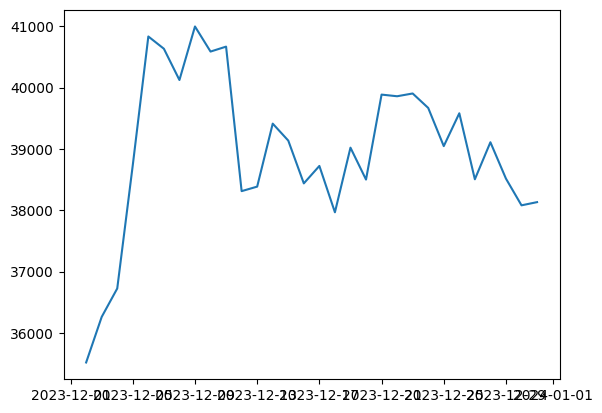

In [10]:
plt.plot(new_data['Timestamp'], new_data['Price'])

# Funzione per testare l'agente su più giorni (simulazione classica)

In [11]:
# Funzione per simulare il trading su dati di test
def simulate_trading_on_test_data(model, dati_test_custom, L=30, initial_cash=1000, initial_btc=0):
    # Inizializza le variabili di portafoglio
    cash = initial_cash
    btc = initial_btc
    
    # Lista per accumulare i dati del log
    log_data = []
    
    # Ciclo su ogni giorno da L in poi per simulare le operazioni di trading
    for i in range(L, len(dati_test_custom)):
        # Crea la finestra dei dati passati di lunghezza L
        historical_data = dati_test_custom.iloc[i-L:i]
        
        # Estrarre il prezzo del giorno corrente
        current_price = dati_test_custom.iloc[i]['Price']
        current_timestamp = dati_test_custom.iloc[i]['Timestamp']
        
        # Usa il modello per prevedere l'azione da compiere oggi
        action = get_trading_action(model, historical_data)
        
        # Determina l'azione (acquisto, vendita o nulla)
        if action > 0:  # Acquisto
            cash_spent = action * cash
            btc_bought = cash_spent / current_price
            cash -= cash_spent
            btc += btc_bought
            action_type = 'Acquisto'
        elif action < 0:  # Vendita
            btc_sold = -action * btc
            cash_earned = btc_sold * current_price
            btc -= btc_sold
            cash += cash_earned
            action_type = 'Vendita'
        else:
            # Nessuna azione
            action_type = '-'
            cash_spent = 0
            btc_bought = 0
            cash_earned = 0
            btc_sold = 0

        # Calcola il valore totale del portafoglio alla fine della giornata
        total_value = cash + btc * current_price
        
        # Aggiungi una nuova riga al log
        log_data.append({
            'Timestamp': current_timestamp,
            'prezzo': current_price,
            'Azione': action_type,
            'Percentuale': action,
            'Liquidità spesa/guadagnata': cash_spent if action_type == 'Acquisto' else cash_earned if action_type == 'Vendita' else '-',
            'Bitcoin spesi/guadagnati': btc_bought if action_type == 'Acquisto' else btc_sold if action_type == 'Vendita' else '-',
            'Liquidità posseduta': cash,
            'bitcoin': btc,
            'valore_totale_portafoglio': total_value
        })
        
    # Converti i dati del log in un DataFrame
    log_df = pd.DataFrame(log_data)
    
    return log_df

In [12]:
# Esecuzione della simulazione di trading sui dati di test
dati_test_custom = dati.iloc[-100:]
log_df = simulate_trading_on_test_data(model, dati_test_custom)

# Visualizzare i primi risultati del log
log_df

,Timestamp,prezzo,Azione,Percentuale,Liquidità spesa/guadagnata,Bitcoin spesi/guadagnati,Liquidità posseduta,bitcoin,valore_totale_portafoglio
0,2023-10-23,28324.646484,Acquisto,0.164952,164.951981,0.005824,835.048035,0.005824,1000.000015
1,2023-10-24,31008.648438,Acquisto,0.813277,679.125000,0.021901,155.923035,0.027725,1015.630623
2,2023-10-25,31996.871094,Acquisto,1.000000,155.923035,0.004873,0.000000,0.032598,1043.028867
3,2023-10-26,32653.228516,Acquisto,0.193034,0.000000,0.000000,0.000000,0.032598,1064.424701
4,2023-10-27,32333.435547,Acquisto,1.000000,0.000000,0.000000,0.000000,0.032598,1054.000141
...,...,...,...,...,...,...,...,...,...
65,2023-12-27,38504.562500,Acquisto,1.000000,0.000000,0.000000,0.000000,0.031319,1205.908020
66,2023-12-28,39108.300781,Vendita,-0.688270,843.004461,0.021556,843.004461,0.009763,1224.816242
67,2023-12-29,38515.289062,Acquisto,0.484242,408.217858,0.010599,434.786603,0.020362,1219.026708
68,2023-12-30,38080.046875,Acquisto,1.000000,434.786603,0.011418,0.000000,0.031779,1210.164399


In [16]:
# Funzione per calcolare la dimensione dei punti in base alla quantità e al massimo valore
def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Filtra gli acquisti e le vendite dal log delle transazioni
acquisti = log_df[(log_df['Azione'] == 'Acquisto') & (log_df['Liquidità spesa/guadagnata'] != 0)]
vendite = log_df[(log_df['Azione'] == 'Vendita') & (log_df['Liquidità spesa/guadagnata'] != 0)]

# Calcola il massimo valore speso per acquistare e il massimo valore guadagnato dalle vendite
max_acquisto = acquisti['Liquidità spesa/guadagnata'].max()
max_vendita = vendite['Liquidità spesa/guadagnata'].max()

# Calcola la dimensione dei punti in base al massimo valore di acquisto e vendita
dimensioni_acquisti = acquisti['Liquidità spesa/guadagnata'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['Liquidità spesa/guadagnata'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico dei prezzi con acquisti e vendite
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(
    x=log_df['Timestamp'],
    y=log_df['prezzo'],
    mode='lines',
    name='Prezzi Bitcoin',
    line=dict(color='blue', width=2),
    hoverinfo='x+y'
))

# Scatter plot per gli acquisti con dimensione proporzionale al valore speso
fig.add_trace(go.Scatter(
    x=acquisti['Timestamp'],
    y=acquisti['prezzo'],
    mode='markers',
    name='Acquisti',
    marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
    text=[
        f"Timestamp: {timestamp}<br>Prezzo: {prezzo} €<br>Percentuale Acquisto: {round(percentuale * 100, 2)}%<br>Liquidità Spesa: {round(liquid_spesa, 2)} €<br>Bitcoin Acquistati: {round(btc_acq, 6)}<br>Liquidità: {round(liquid_tot, 2)} €<br>Bitcoin: {round(btc_poss, 6)}<br>Valore Portafoglio: {round(valore_port, 2)} €"
        for timestamp, prezzo, percentuale, liquid_spesa, btc_acq, liquid_tot, btc_poss, valore_port in zip(
            acquisti['Timestamp'],
            acquisti['prezzo'],
            acquisti['Percentuale'],
            acquisti['Liquidità spesa/guadagnata'],
            acquisti['Bitcoin spesi/guadagnati'],
            acquisti['Liquidità posseduta'],
            acquisti['bitcoin'],
            acquisti['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Scatter plot per le vendite con dimensione proporzionale al valore guadagnato
fig.add_trace(go.Scatter(
    x=vendite['Timestamp'],
    y=vendite['prezzo'],
    mode='markers',
    name='Vendite',
    marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
    text=[
        f"Timestamp: {timestamp}<br>Prezzo: {prezzo} €<br>Percentuale Vendita: {round(percentuale * 100, 2)}%<br>Liquidità Guadagnata: {round(liquid_guad, 2)} €<br>Bitcoin Venduti: {round(btc_vend, 6)}<br>Liquidità: {round(liquid_tot, 2)} €<br>Bitcoin: {round(btc_poss, 6)}<br>Valore Portafoglio: {round(valore_port, 2)} €"
        for timestamp, prezzo, percentuale, liquid_guad, btc_vend, liquid_tot, btc_poss, valore_port in zip(
            vendite['Timestamp'],
            vendite['prezzo'],
            vendite['Percentuale'],
            vendite['Liquidità spesa/guadagnata'],
            vendite['Bitcoin spesi/guadagnati'],
            vendite['Liquidità posseduta'],
            vendite['bitcoin'],
            vendite['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Configurazione del layout del grafico
fig.update_layout(
    title='Andamento Prezzi Bitcoin con Transazioni di Acquisto e Vendita',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width=1200,
    height=800,
    xaxis=dict(
        rangeslider=dict(visible=True),  # Abilita il range slider
        type="date"  # Imposta l'asse x come asse temporale
    )
)

# Mostra il grafico interattivo
fig.show()